In [1]:
import sys
sys.path.append('./src')

from linear import *
import numpy as np
from loss import *
from matplotlib import pyplot as plt
import tools
from non_lineare import *

# Lineare

### donnée lineare (regression lineare données y est linearement dependent a x)

In [2]:
def generate_data_lin(alpha,beta):
    x= np.random.uniform(-10,10,alpha).reshape((-1,1))
    e= (np.random.uniform(-100,100,alpha)).reshape((-1,1))  
    y = alpha * x + beta + e 
    return x,y

#deffintion 
x_lin, y_lin = generate_data_lin(30, 10)
loss_mse = MSELoss()


/tmp/ipykernel_49734/1985103692.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


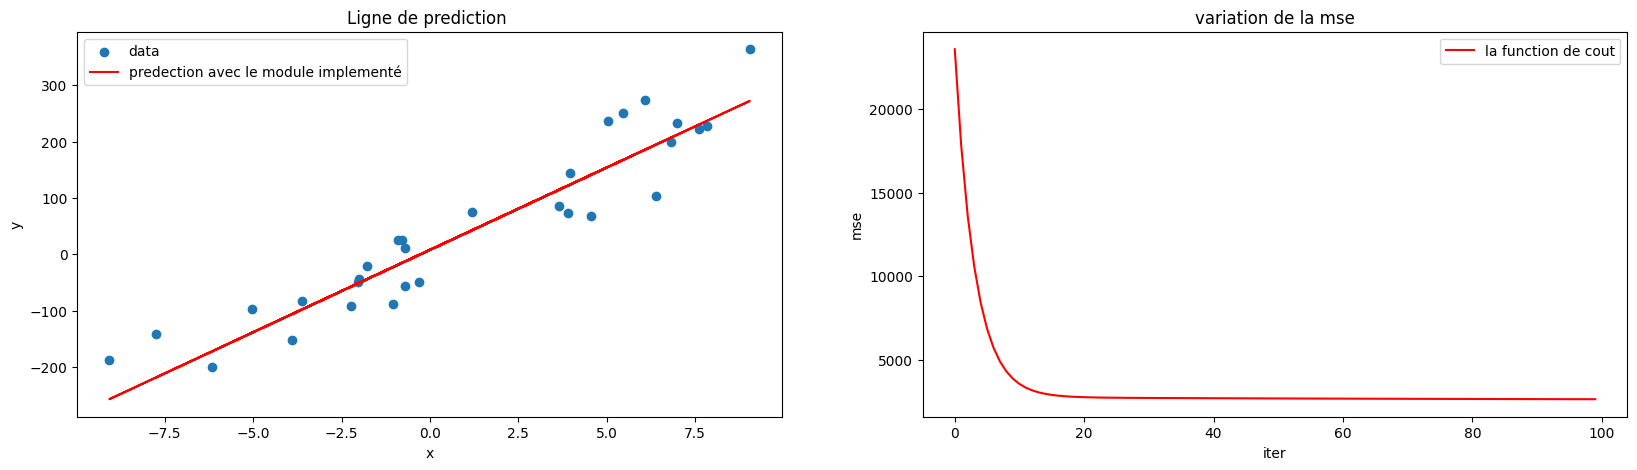

In [3]:
# reseau non profond
# un seul modul d=1,d'=1 un seul neurronne
# lineare

module_lin = Linear(x_lin.shape[1], 1)
iter=100
hist_loss=[]

for _ in range(iter):

    #forward avoir z_h
    y_hat = module_lin.forward(x_lin)
    
    hist_loss.append(loss_mse.forward(y_lin,y_hat).mean())

    #backward calculer dervie de l par rapport z_h
    loss_back = loss_mse.backward(y_lin, y_hat)
        
    module_lin.backward_update_gradient(x_lin, loss_back)
    module_lin.update_parameters(gradient_step=1e-4)
    
    module_lin.zero_grad()


y_hat=module_lin.forward(x_lin)

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(20,5))
ax.flatten()

ax[0].scatter(x_lin,y_lin,label="data")
ax[0].plot(x_lin,y_hat,color='red',label='predection avec le module implementé')
ax[0].legend()
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Ligne de prediction ")

ax[1].plot(np.arange(iter),hist_loss,color='red',label="la function de cout")
ax[1].legend()
ax[1].set_xlabel("iter")
ax[1].set_ylabel("mse")
ax[1].set_title("variation de la mse")

fig.show()

### claasification binaire (données linearement separable)

/tmp/ipykernel_49734/2142189406.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


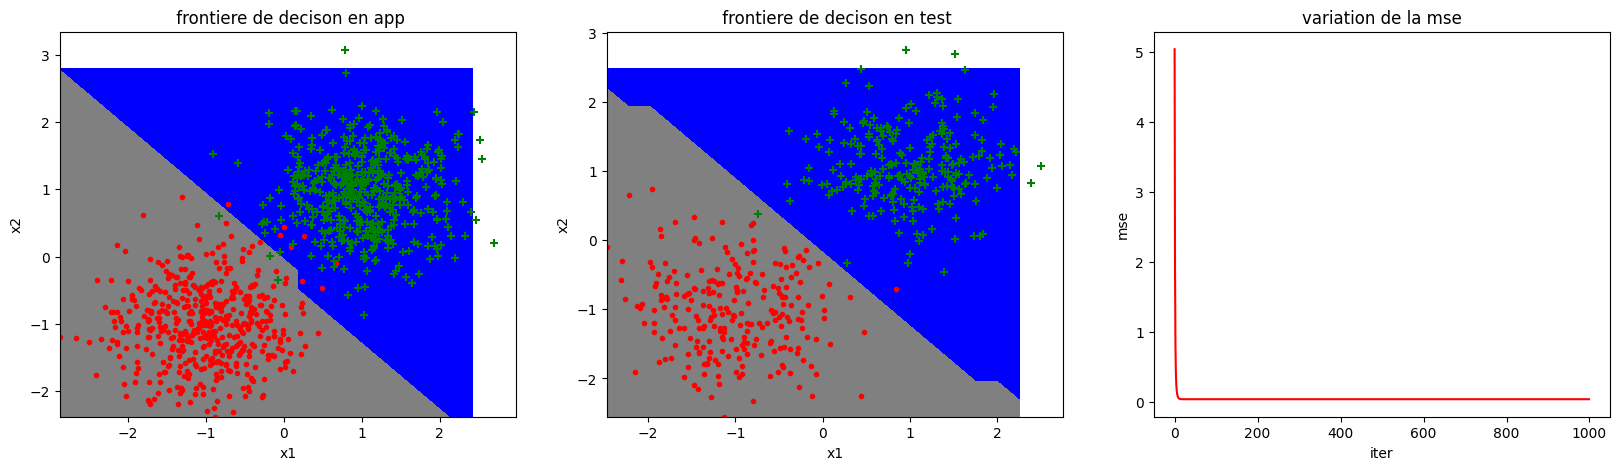

In [4]:
# on a besoin d'un seul nourronne donc d=2, d'=1 (simple aussi) 

batch=1000

x_class, y_class = tools.gen_arti(sigma=0.3, nbex=batch, data_type=0, epsilon=0.1)
x_class_t, y_class_t = tools.gen_arti(sigma=0.3, nbex=500, data_type=0, epsilon=0.1)

y_class = np.where(y_class==-1,0,1).reshape((-1,1))
y_class_t = np.where(y_class_t==-1,0,1).reshape((-1,1))

loss_mse = MSELoss()
module_lin = Linear(x_class.shape[1], 1)

iter=1000
hist_loss=[]

for _ in range(iter):

    #forward avoir z_h
    y_hat = module_lin.forward(x_class)
    
    hist_loss.append(loss_mse.forward(y_class,y_hat).mean())

    #backward calculer dervie de l par rapport z_h
    loss_back = loss_mse.backward(y_class, y_hat)
        
    module_lin.backward_update_gradient(x_class, loss_back)
    module_lin.update_parameters(gradient_step=1e-4)
    
    module_lin.zero_grad()


y_hat=module_lin.forward(x_class)

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(20,5))
ax.flatten()


def sign(x):
    return np.where(module_lin.forward(x)>0.5,1,0)


tools.plot_frontiere(x_class,sign,ax=ax[0])
tools.plot_data(x_class, y_class,ax[0])
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].set_title(" frontiere de decison en app")

tools.plot_frontiere(x_class_t,sign,ax=ax[1])
tools.plot_data(x_class_t, y_class_t,ax[1])
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].set_title(" frontiere de decison en test")


ax[2].plot(np.arange(iter),hist_loss,color='red',label="la function de cout")
ax[2].set_xlabel("iter")
ax[2].set_ylabel("mse")
ax[2].set_title("variation de la mse")
fig.show()


### Non linearement separable

accuracy :  0.989


/tmp/ipykernel_50509/2680353315.py:78: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


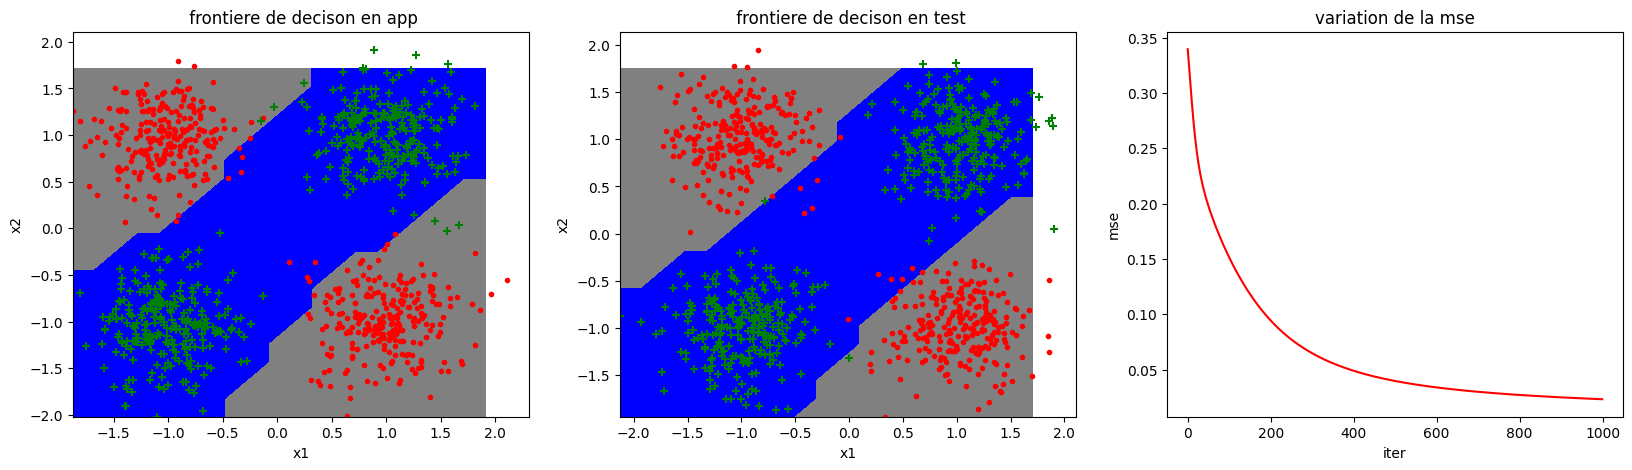

In [2]:

size =1000

datax, datay = tools.gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)
testx, testy = tools.gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)

datay = np.where(datay==-1,0,1).reshape((-1,1))
testy = np.where(testy==-1,0,1).reshape((-1,1))

loss_mse = MSELoss()
modul_lin1 = Linear( datax.shape[1], 4)
modul_lin2 = Linear(4, 1)
modul_sig = Sigmoide()
modul_tan = TanH()


l_loss=[]
iter=1000


for _ in range(iter):
    
    #forward
    new_feautre_lin_1 = modul_lin1.forward(datax)   
    new_feautre_activation_1 = modul_tan.forward(new_feautre_lin_1)
    new_feautre_lin_2 = modul_lin2.forward(new_feautre_activation_1)
    y_hat = modul_sig.forward(new_feautre_lin_2)
    loss = loss_mse.forward(datay,y_hat)
    l_loss.append(loss.mean())
    
    #backward
    loss_back = loss_mse.backward(datay, y_hat)
    delta_sig = modul_sig.backward_delta(new_feautre_lin_2,loss_back)
    delta_lin2 = modul_lin2.backward_delta(new_feautre_activation_1,delta_sig)
    delta_tan = modul_tan.backward_delta(new_feautre_lin_1,delta_lin2)
    delta_lin1 = modul_lin1.backward_delta(datax,delta_tan)


    modul_lin2.backward_update_gradient(new_feautre_activation_1, delta_sig)
    modul_lin1.backward_update_gradient(datax, delta_tan)    

    modul_lin2.update_parameters(gradient_step = 1e-4)
    modul_lin1.update_parameters(gradient_step = 1e-4)
    
    modul_lin1.zero_grad()
    modul_lin2.zero_grad()
    


def predict(x):
    hidden_l = modul_lin1.forward(x)
    hidden_l = modul_tan.forward(hidden_l)
    hidden_l = modul_lin2.forward(hidden_l)
    hidden_l = modul_sig.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

print("accuracy : ",np.where(testy == predict(testx),1,0).mean())

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(20,5))
ax.flatten()

tools.plot_frontiere(datax,predict,ax=ax[0])
tools.plot_data(datax, datay,ax[0])
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].set_title(" frontiere de decison en app")

tools.plot_frontiere(testx,predict,ax=ax[1])
tools.plot_data(testx, testy,ax[1])
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].set_title(" frontiere de decison en test")


ax[2].plot(np.arange(iter),l_loss,color='red',label="la function de cout")
ax[2].set_xlabel("iter")
ax[2].set_ylabel("mse")
ax[2].set_title("variation de la mse")
fig.show()


### Xor (données nos linearement separable)

accuracy :  0.5


/tmp/ipykernel_50509/2391230371.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


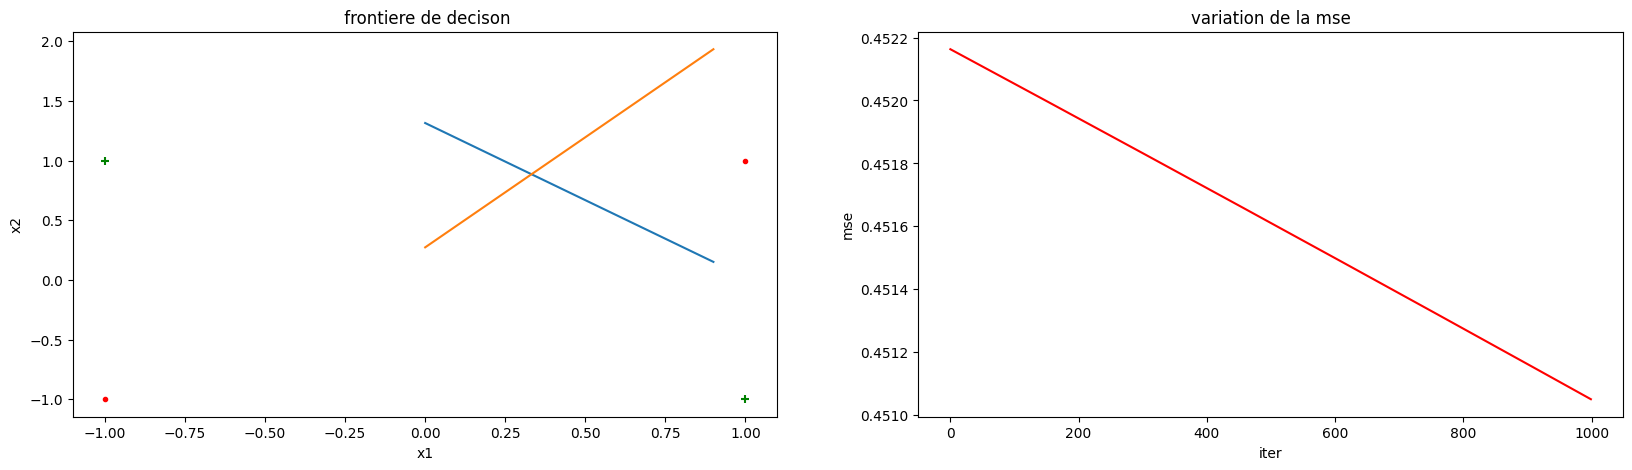

In [9]:
# on a besoin de 2 hyperplan 

x_xor = np.array([[-1,1],[1,-1],[1,1],[-1,-1]])
y_xor = np.array([[1],[1],[-1],[-1]])

y_xor = np.where(y_xor==-1,0,1).reshape((-1,1))

loss_mse = MSELoss()
modul_lin1 = Linear( x_xor.shape[1], 2)
modul_lin2 = Linear(2, 1)
modul_sig = Sigmoide()
modul_tan = TanH()

l_loss=[]

for _ in range(1000):
    
    #forward
    new_feautre_lin_1 = modul_lin1.forward(x_xor)   
    new_feautre_activation_1 = modul_tan.forward(new_feautre_lin_1)
    new_feautre_lin_2 = modul_lin2.forward(new_feautre_activation_1)
    y_hat = modul_sig.forward(new_feautre_lin_2)
    loss = loss_mse.forward(y_xor,y_hat)
    l_loss.append(loss.mean())
    
    #backward
    loss_back = loss_mse.backward(y_xor, y_hat)
    delta_sig = modul_sig.backward_delta(new_feautre_lin_2,loss_back)
    delta_lin2 = modul_lin2.backward_delta(new_feautre_activation_1,delta_sig)
    delta_tan = modul_tan.backward_delta(new_feautre_lin_1,delta_lin2)
    delta_lin1 = modul_lin1.backward_delta(x_xor,delta_tan)


    modul_lin2.backward_update_gradient(new_feautre_activation_1, delta_sig)
    modul_lin1.backward_update_gradient(x_xor, delta_tan)    

    modul_lin2.update_parameters(gradient_step = 1e-4)
    modul_lin1.update_parameters(gradient_step = 1e-4)
    
    modul_lin1.zero_grad()
    modul_lin2.zero_grad()
    


def predict(x):
    hidden_l = modul_lin1.forward(x)
    hidden_l = modul_tan.forward(hidden_l)
    hidden_l = modul_lin2.forward(hidden_l)
    hidden_l = modul_sig.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

print("accuracy : ",np.where(y_xor == predict(x_xor),1,0).mean())

y0= lambda x : (modul_lin1._parameters[0,0]*x+modul_lin1._biais[0,0])/modul_lin1._parameters[0,1]
y1= lambda x : (modul_lin1._parameters[1,0]*x+modul_lin1._biais[0,1])/modul_lin1._parameters[1,1]

x=np.arange(0, 1, 0.1)

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(20,5))
ax.flatten()

tools.plot_data(x_xor, y_xor,ax=ax[0])
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].set_title(" frontiere de decison")
ax[0].plot(x,y0(x))
ax[0].plot(x,y1(x))

ax[1].plot(np.arange(iter),l_loss,color='red',label="la function de cout")
ax[1].set_xlabel("iter")
ax[1].set_ylabel("mse")
ax[1].set_title("variation de la mse")
fig.show()